# Build the LSLGA parent sample

The purpose of this notebook is to build the parent sample for the NASA Legacy Surveys Galaxy Atlas (NLSGA).

Our starting catalog is the file *ned-d25min10.txt*, which contains 8,131,378 objects and is the (semi-raw) output of querying the NED database (on 2018 March 26) for all objects with a D(25) isophotal diameter (in any band) greater than 10 arcsec, with no requirements on redshift or object type.  

Next, we run
```bash
% time python parse-ned-sample
```
to restrict the sample to just "galaxies" (object type "G", "GGroup", "GPair", "GTrpl", or "PofG"), which leaves 4,755,411 objects, and to write out a more conveniently formatted FITS file, *ned-d25min10.fits*.  

Specifically, we parse and merge various apparent magnitude estimates (from SDSS/r, 2MASS/Ks, RC3/B, and APM/bJ, in that order of priority), and angular diameters (D25), minor-to-major axis ratios (b/a), and position angles (pa) (from SDSS, 2MASS, RC3, and ESO, in that order of priority).

### Imports and paths

In [1]:
import os
import numpy as np
import numpy.ma as ma
import pandas as pd

In [2]:
from astropy.table import Table

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
sns.set(style='ticks', font_scale=1.5, palette='Set2')
%matplotlib inline

In [30]:
NLSGAdir = os.getenv('LSLGA_DIR')
nedfile = os.path.join(NLSGAdir, 'sample', 'ned-d25min10.fits')

### Read the parsed catalog.

In [32]:
print('Reading {}'.format(nedfile))
cat = Table.read(nedfile)
cat

Reading /Users/ioannis/research/projects/LSLGA/sample/ned-d25min10.fits


galaxy,objtype,ra,dec,z,zqual,morph,mag,mag_err,mag_band,d25,d25_band,ba25,ba25_band,pa,pa_band,notes
bytes28,bytes6,float64,float64,float32,bytes4,bytes22,float64,float64,bytes5,float64,bytes5,float64,bytes5,float64,bytes5,bytes75
SDSS J104850.24+025502.5,G,162.209375,2.91736111111,nan,N/A,N/A,18.8470267683,nan,r,10.0600004196,r,0.446999996901,r,133.0,r,N/A
2MASX J09033941-0733105,G,135.91425,-7.553,nan,N/A,N/A,15.6804962158,0.28542548418,Ks,10.1999998093,Ks,1.0,Ks,90.0,Ks,N/A
SDSS J140752.05+264526.8,G,211.966916667,26.7574444444,nan,N/A,N/A,22.6303603421,nan,r,17.0100002289,r,0.0930000022054,r,8.0,r,N/A
SDSS J113215.64+344212.9,G,173.065208333,34.7036111111,0.27272,N/A,N/A,17.6269936756,nan,r,19.2099990845,r,0.509000003338,r,170.0,r,N/A
2MASX J22191656-6344382,G,334.818833333,-63.7439444444,nan,N/A,N/A,15.0213737488,0.164080351591,Ks,15.0,Ks,0.699999988079,Ks,10.0,Ks,N/A
SDSS J120147.71-033609.5,G,180.448791667,-3.60263888889,nan,N/A,N/A,21.5587156623,nan,r,3.8900001049,r,0.617999970913,r,117.0,r,N/A
SDSS J114500.79+150010.4,G,176.253291667,15.0029166667,0.336505,N/A,N/A,18.5192791414,nan,r,10.3999996185,r,0.735000014305,r,48.0,r,N/A
2MASX J11564998+2701421,G,179.20825,27.0283333333,0.159669,N/A,N/A,17.5398298857,0.238436192274,r,14.7600002289,r,0.672999978065,r,7.0,r,N/A
SDSS J095550.81+004114.1,G,148.961708333,0.687277777778,0.095322,N/A,N/A,17.037313044,0.127010643482,r,21.8700008392,r,0.333000004292,r,105.0,r,N/A


In [35]:
def qa_radec():
    fig, ax = plt.subplots()
    ax.scatter(cat['ra'], cat['dec'], alpha=0.5, s=10, label='NED Catalog')
    #ax.scatter(sample['ra'], sample['dec'], s=20, label='Objects in DR6 Footprint')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.legend(loc='lower right')

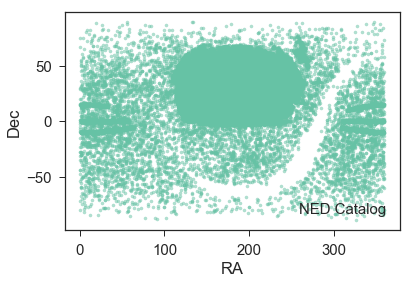

In [36]:
qa_radec()

In [ ]:
stop

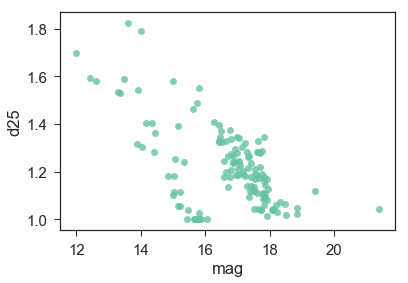

In [25]:
sns.regplot(x=out['mag'], y=np.log10(out['d25']), fit_reg=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a20163cc0>]], dtype=object)

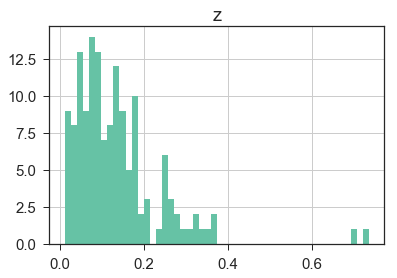

In [27]:
out.hist(column='z', bins=50)

In [28]:
out['z'].describe()

count    144.000000
mean       0.133731
std        0.107889
min        0.011290
25%        0.064311
50%        0.105830
75%        0.172098
max        0.734850
Name: z, dtype: float64

In [15]:
stop

NameError: name 'stop' is not defined

In [ ]:
data.loc[15]

In [ ]:
data['sdss_d25'], data['twomass_d25']

### Read the parent HyperLeda catalog

In [ ]:
def _catalog_template(nobj=1):
    cols = [
        ('GALAXY', 'S28'), 
        ('PGC', 'S10'), 
        ('RA', 'f8'), 
        ('DEC', 'f8'),
        ('TYPE', 'S8'),
        ('MULTIPLE', 'S1'),
        ('RADIUS', 'f4'),
        ('BA', 'f4'),
        ('PA', 'f4'),
        ('BMAG', 'f4'),
        ('IMAG', 'f4'),
        ('VHELIO', 'f4'),
        ('BRICKNAME', 'S17', (4,))
        ]
    catalog = Table(np.zeros(nobj, dtype=cols))
    catalog['RADIUS'].unit = 'arcsec'
    catalog['VHELIO'].unit = 'km/s'

    return catalog

In [ ]:
def read_leda(largedir='.', d25min=0.0, d25max=1000.0, decmin=-90.0, 
              decmax=+90.0, ramin=0.0, ramax=360.0):
    """Read the parent LEDA catalog and put it in a standard format.
    
    """
    cat = fits.getdata(os.path.join(largedir, 'sample', 'leda-logd25-0.05.fits.gz'), 1)

    outcat = _catalog_template(len(cat))
    outcat['GALAXY'] = cat['GALAXY']
    outcat['PGC'] = cat['PGC']
    outcat['RA'] = cat['RA']
    outcat['DEC'] = cat['DEC']
    outcat['TYPE'] = cat['TYPE']
    outcat['MULTIPLE'] = cat['MULTIPLE']
    outcat['RADIUS'] = cat['D25']/2.0 # semi-major axis radius [arcsec]
    outcat['BA'] = cat['BA']
    outcat['PA'] = cat['PA']
    outcat['BMAG'] = cat['BMAG']
    outcat['IMAG'] = cat['IMAG']
    outcat['VHELIO'] = cat['VHELIO']

    these = np.where((outcat['RADIUS']*2/60.0 <= d25max) *
                     (outcat['RADIUS']*2/60.0 >= d25min) *
                     (outcat['DEC'] <= decmax) *
                     (outcat['DEC'] >= decmin) *
                     (outcat['RA'] <= ramax) *
                     (outcat['RA'] >= ramin)
                     )[0]
    outcat = outcat[these] 

    return outcat

In [ ]:
survey = LegacySurveyData()

In [ ]:
bricks = survey.get_bricks()
allccds = survey.get_annotated_ccds()
cut = survey.photometric_ccds(allccds)
if cut is not None:
    allccds.cut(cut)
cut = survey.ccd_cuts(allccds)
allccds.cut(cut == 0)
print('Read {} CCDs.'.format(len(allccds)))

In [ ]:
        # Read the parent super-sample.
        if False:
            print('Testing with smaller sample cuts!')
            d25min, d25max = 1.0, 5.0
            ramin, ramax = 175, 185
        else:
            d25min, d25max = 0.5, 10.0
            ramin, ramax = 0, 360

        cat = read_leda(largedir=largedir, d25min=d25min, d25max=d25max,
                        decmax=np.max(allccds.dec)+0.3,
                        decmin=np.min(allccds.dec)-0.3,


### Build the parent sample

In [ ]:
def _build_sample_onegalaxy(args):
    """Filler function for the multiprocessing."""
    return build_sample_onegalaxy(*args)

In [ ]:
def build_sample_onegalaxy(gal, allccds, ccdsdir, bricks, survey):
    """Wrapper function to find overlapping CCDs for a given galaxy.

    First generously find the nearest set of CCDs that are near the galaxy and
    then demand that there's 3-band coverage in a much smaller region centered
    on the galaxy.

    """
    #print('Working on {}...'.format(gal['GALAXY'].strip()))
    galwcs = _galwcs(gal)
    these = ccds_touching_wcs(galwcs, allccds)

    if len(these) > 0:
        ccds1 = _uniqccds( allccds[these] )

        # Is there 3-band coverage?
        galwcs_small = _galwcs(gal, factor=0.5)
        these_small = ccds_touching_wcs(galwcs_small, ccds1)
        ccds1_small = _uniqccds( ccds1[these_small] )

        if 'g' in ccds1_small.filter and 'r' in ccds1_small.filter and 'z' in ccds1_small.filter:
            print('For {} found {} CCDs, RA = {:.5f}, Dec = {:.5f}, Radius={:.4f} arcsec'.format(
                gal['GALAXY'].strip(), len(ccds1), gal['RA'], gal['DEC'], gal['RADIUS']))

            ccdsfile = os.path.join(ccdsdir, '{}-ccds.fits'.format(gal['GALAXY'].strip().lower()))
            #print('  Writing {}'.format(ccdsfile))
            if os.path.isfile(ccdsfile):
                os.remove(ccdsfile)
            ccds1.writeto(ccdsfile)

            # Also get the set of bricks touching this footprint.
            rad = 2*gal['RADIUS']/3600 # [degree]
            brickindx = survey.bricks_touching_radec_box(bricks,
                                                         gal['RA']-rad, gal['RA']+rad,
                                                         gal['DEC']-rad, gal['DEC']+rad)
            if len(brickindx) == 0 or len(brickindx) > 4:
                print('This should not happen!')
                pdb.set_trace()
            gal['BRICKNAME'][:len(brickindx)] = bricks.brickname[brickindx]

            return [gal, ccds1]

    return None


In [ ]:
samplefile = os.path.join(LSLGAdir, 'sample', 'large-galaxies-{}.fits'.format(dr))
sample = fits.getdata(samplefile, 1)